In [1]:
from data_exploration import *
from imports import *

In [2]:
data_path = 'C:\\Users\\homol\\Documents\\diplomamunka\\adat\\tweets_2015_2020'

In [3]:
tweet_df_list = []
stock_df_list = []
symbol_list = ['TSLA','AAPL','GOOG','GOOGL','AMZN','MSFT']
for symbol in symbol_list:
    tweet_df, stock_df = load(data_path,symbol)
    tweet_df_list.append(tweet_df)
    stock_df_list.append(stock_df)

In [4]:
def logreturn(stock_df):
    ordered_df = stock_df.sort_values('date')
    ordered_df['close_value'] = ordered_df['close_value'].apply(lambda x:np.log(x))
    diff_df = ordered_df[['close_value']].diff()
    stock_df['logreturn'] = diff_df['close_value']
    #stock_df = stock_df.rename(columns={"day_date": "date"})
    return stock_df

In [5]:
logreturn_df_list = []
for stock_df in stock_df_list:
    logreturn_df = logreturn(stock_df)
    logreturn_df_list.append(logreturn_df)

In [6]:
def get_confident_df(tweet_df):
    # reducing the dataframe only the neccessary cols
    max_value_df = tweet_df[['date','neutral','positive','negative']]
    # choosing the max value of the row 
    max_value_df['max_value'] = max_value_df[['neutral','positive','negative']].max(axis=1) 

    # the sentiment score is at least 0.8 
    confident_df = max_value_df.loc[max_value_df['max_value']>=0.8].reset_index(drop=True)
    #unconfident_df = max_value_df.loc[max_value_df['max_value'] < 0.8].reset_index(drop=True)

    # choosing the max value label
    confident_df['max_value_label'] = confident_df[['neutral','positive','negative']].idxmax(axis=1)
    #unconfident_df['max_value_label'] = unconfident_df[['neutral','positive','negative']].idxmax(axis=1)

    return confident_df

In [7]:
confident_df_list = []
for tweet_df in tweet_df_list:
    confident_df = get_confident_df(tweet_df)
    confident_df_list.append(confident_df)

C:\Users\homol\AppData\Local\Temp/ipykernel_26196/2816503892.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_value_df['max_value'] = max_value_df[['neutral','positive','negative']].max(axis=1)


In [8]:
def get_tweet_volume_df(conf_df):
    tweet_volume_df = conf_df.groupby('date').count().reset_index(drop=False)
    tweet_volume_df['tweet_volume'] = tweet_volume_df['neutral']
    tweet_volume_df = tweet_volume_df[['date','tweet_volume']]
    return tweet_volume_df

In [9]:
tweet_volume_df_list = []
for conf_df in confident_df_list:
    tweet_volume_df = get_tweet_volume_df(conf_df)
    tweet_volume_df_list.append(tweet_volume_df)

In [10]:
def get_ratio_df(conf_df):
    # conf:given_day_pos/given_day_all
    date_list = conf_df['date'].unique()
    pos_ratio_dict = {}
    neg_ratio_dict = {}
    for date in date_list:
        day_df = conf_df.loc[conf_df['date'] == date].reset_index(drop=True) 
        all_label = len(day_df)
        pos_label = len(day_df.loc[day_df['max_value_label'] == 'positive'].reset_index(drop=True))
        neg_label = len(day_df.loc[day_df['max_value_label'] == 'negative'].reset_index(drop=True))
        pos_ratio_dict[date] = pos_label/all_label
        neg_ratio_dict[date] = neg_label/all_label
        
    pos_ratio_df = pd.DataFrame(pos_ratio_dict.items(), columns=['date', 'pos_ratio'])
    neg_ratio_df = pd.DataFrame(neg_ratio_dict.items(), columns=['date', 'neg_ratio'])
    return pos_ratio_df, neg_ratio_df

In [11]:
def get_sent_df(conf_df):
    date_list = conf_df['date'].unique()
    pos_dict = {}
    neg_dict = {}
    for date in date_list:
        day_df = conf_df.loc[conf_df['date'] == date].reset_index(drop=True) 
        pos_label = len(day_df.loc[day_df['max_value_label'] == 'positive'].reset_index(drop=True))
        neg_label = len(day_df.loc[day_df['max_value_label'] == 'negative'].reset_index(drop=True))
        pos_dict[date] = pos_label
        neg_dict[date] = neg_label
        
    pos_df = pd.DataFrame(pos_dict.items(), columns=['date', 'pos_num'])
    neg_df = pd.DataFrame(neg_dict.items(), columns=['date', 'neg_num'])
    return pos_df, neg_df

In [12]:
def merge_ratio_df(pos_df,neg_df):
    sent_df = pd.merge(pos_df, neg_df,on='date')
    return sent_df

In [13]:
def merge_sent_logreturn(sent_df,logreturn_df):
    logreturn_sent_df = pd.merge(logreturn_df[['date','logreturn']],sent_df,on='date')
    return logreturn_sent_df

In [14]:
ratio_df_list = []
for conf_df in confident_df_list:
    pos_ratio_df, neg_ratio_df = get_ratio_df(conf_df)
    ratio_df = merge_ratio_df(pos_ratio_df,neg_ratio_df)
    ratio_df_list.append(ratio_df)

In [15]:
sent_df_list = []
for conf_df in confident_df_list:
    pos_df, neg_df = get_sent_df(conf_df)
    sent_df = merge_ratio_df(pos_df,neg_df)
    sent_df_list.append(sent_df)

In [16]:
final_ratio_df_list = []
for i,ratio_df in enumerate(ratio_df_list):
    logreturn_sent_df = merge_sent_logreturn(ratio_df,logreturn_df_list[i])
    final_ratio_df = pd.merge(logreturn_sent_df[['date','logreturn','pos_ratio','neg_ratio']],
                        tweet_volume_df_list[i], on='date').sort_values('logreturn',ascending=False).reset_index(drop=True)
    final_ratio_df_list.append(final_ratio_df)

In [17]:
final_df_list = []
for i,sent_df in enumerate(sent_df_list):
    logreturn_sent_df = merge_sent_logreturn(sent_df,logreturn_df_list[i])
    final_df = pd.merge(logreturn_sent_df[['date','logreturn','pos_num','neg_num']],
                        tweet_volume_df_list[i], on='date').sort_values('logreturn',ascending=False).reset_index(drop=True)
    final_df_list.append(final_df)

In [18]:
sent_df_list[0]

,date,pos_num,neg_num
0,2015-01-01,5,2
1,2015-01-02,7,13
2,2015-01-03,2,2
3,2015-01-04,2,3
4,2015-01-05,8,14
...,...,...,...
1822,2019-12-28,60,30
1823,2019-12-29,69,44
1824,2019-12-30,157,104
1825,2019-12-31,154,73


In [19]:
ratio_df_list[0]

,date,pos_ratio,neg_ratio
0,2015-01-01,0.065789,0.026316
1,2015-01-02,0.050000,0.092857
2,2015-01-03,0.031250,0.031250
3,2015-01-04,0.020619,0.030928
4,2015-01-05,0.036697,0.064220
...,...,...,...
1822,2019-12-28,0.098200,0.049100
1823,2019-12-29,0.118966,0.075862
1824,2019-12-30,0.124013,0.082148
1825,2019-12-31,0.146249,0.069326


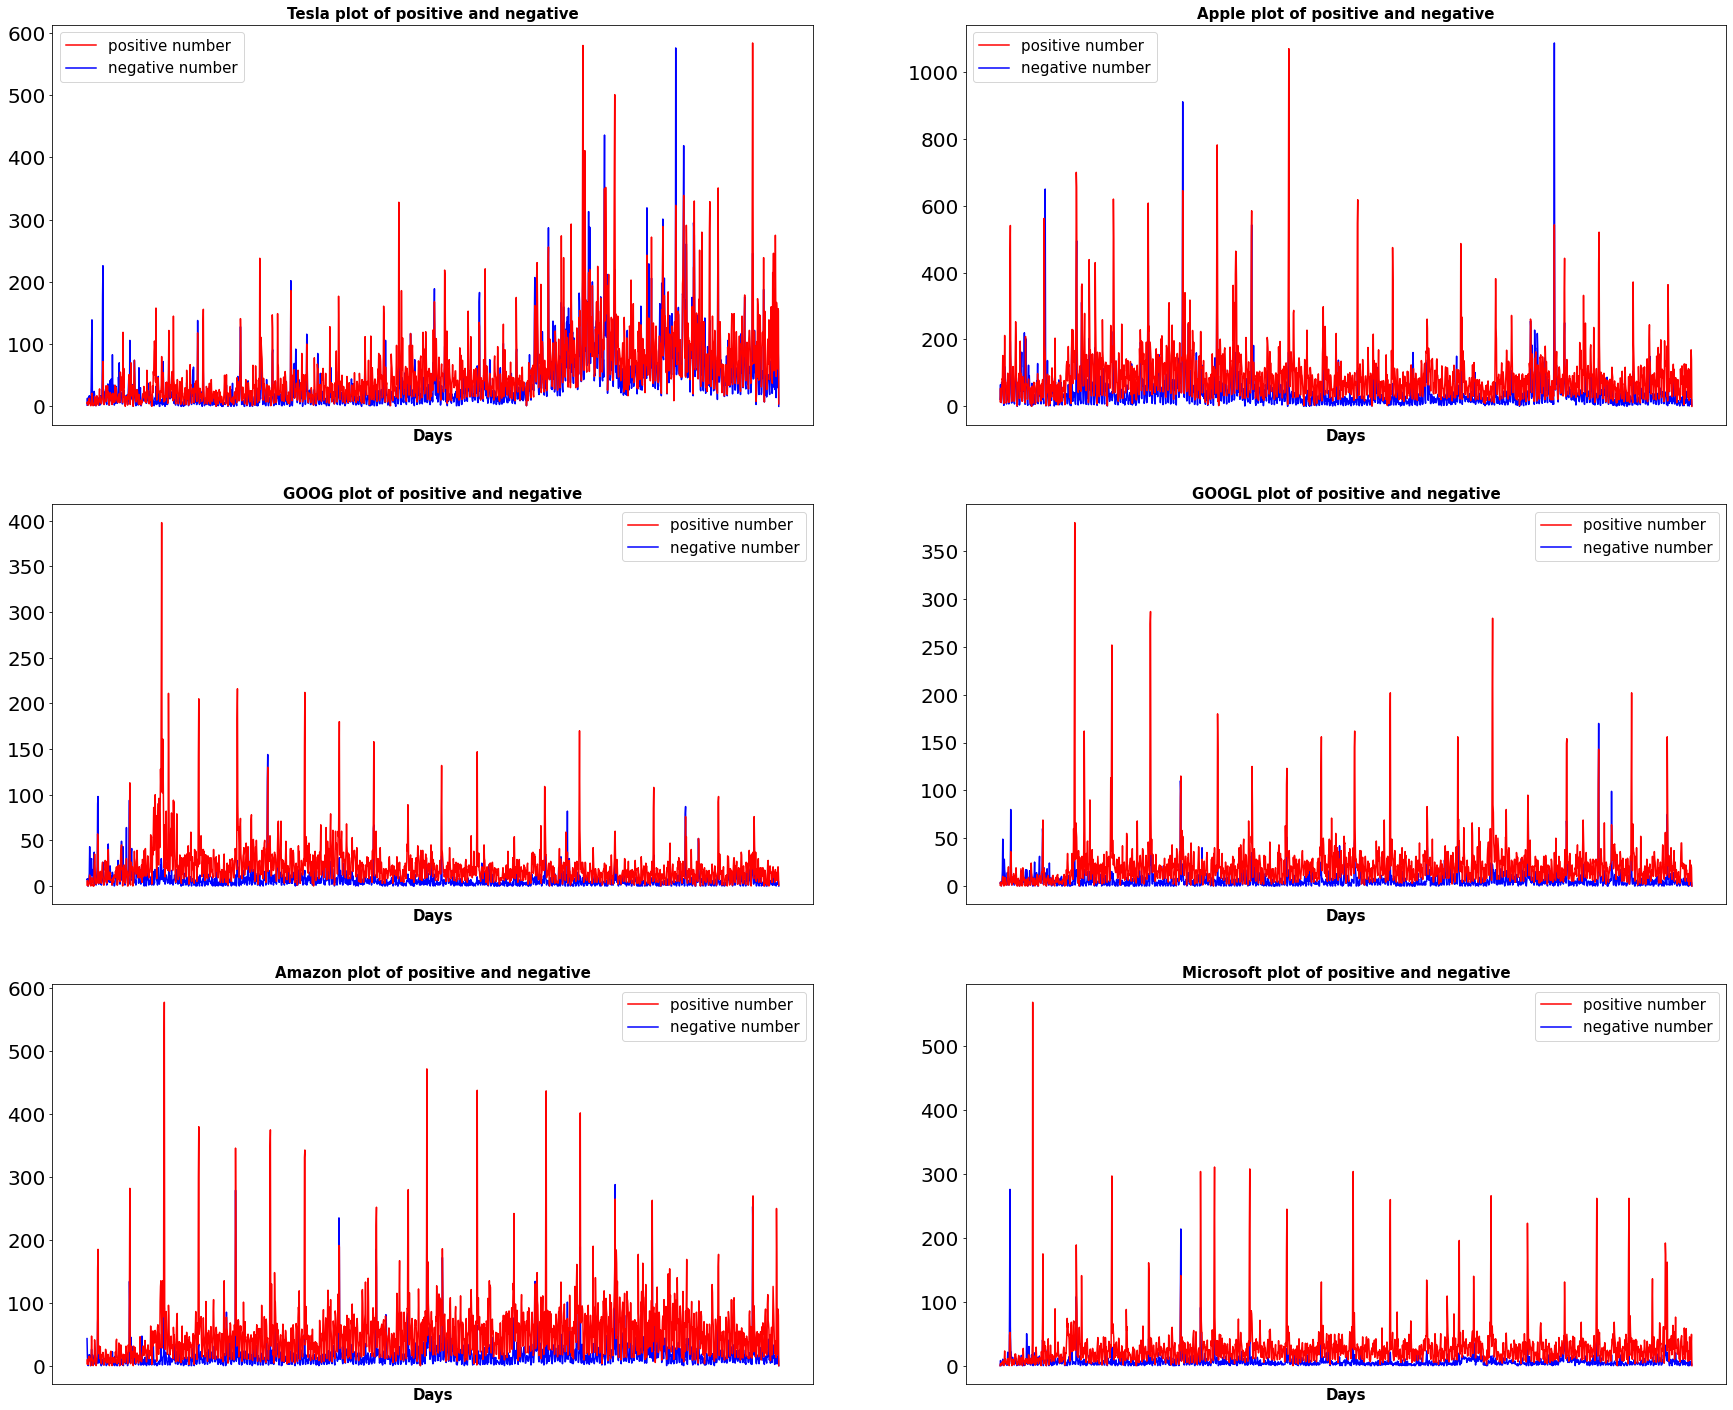

In [20]:
company_name_list = ['Tesla', 'Apple', 'GOOG', 'GOOGL', 'Amazon', 'Microsoft']

fig, axes = plt.subplots(3,2,figsize=(30,25))
axes_list = axes.flatten() #sublots axes

for i,ax in enumerate(axes_list):
    ax.set_title(f'{company_name_list[i]} plot of positive and negative',
                 fontdict={'fontsize':15,'fontweight' : 'bold'})
    c2, = ax.plot(sent_df_list[i]['date'],sent_df_list[i]['neg_num'],color="blue")
    c1, = ax.plot(sent_df_list[i]['date'],sent_df_list[i]['pos_num'],color="red",)
    

    ax.legend([c1, c2,],['positive number', 'negative number'],fontsize=15)
    ax.set_xlabel('Days',fontsize=15, fontweight='bold')
    ax.set_xticks([])
    
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)

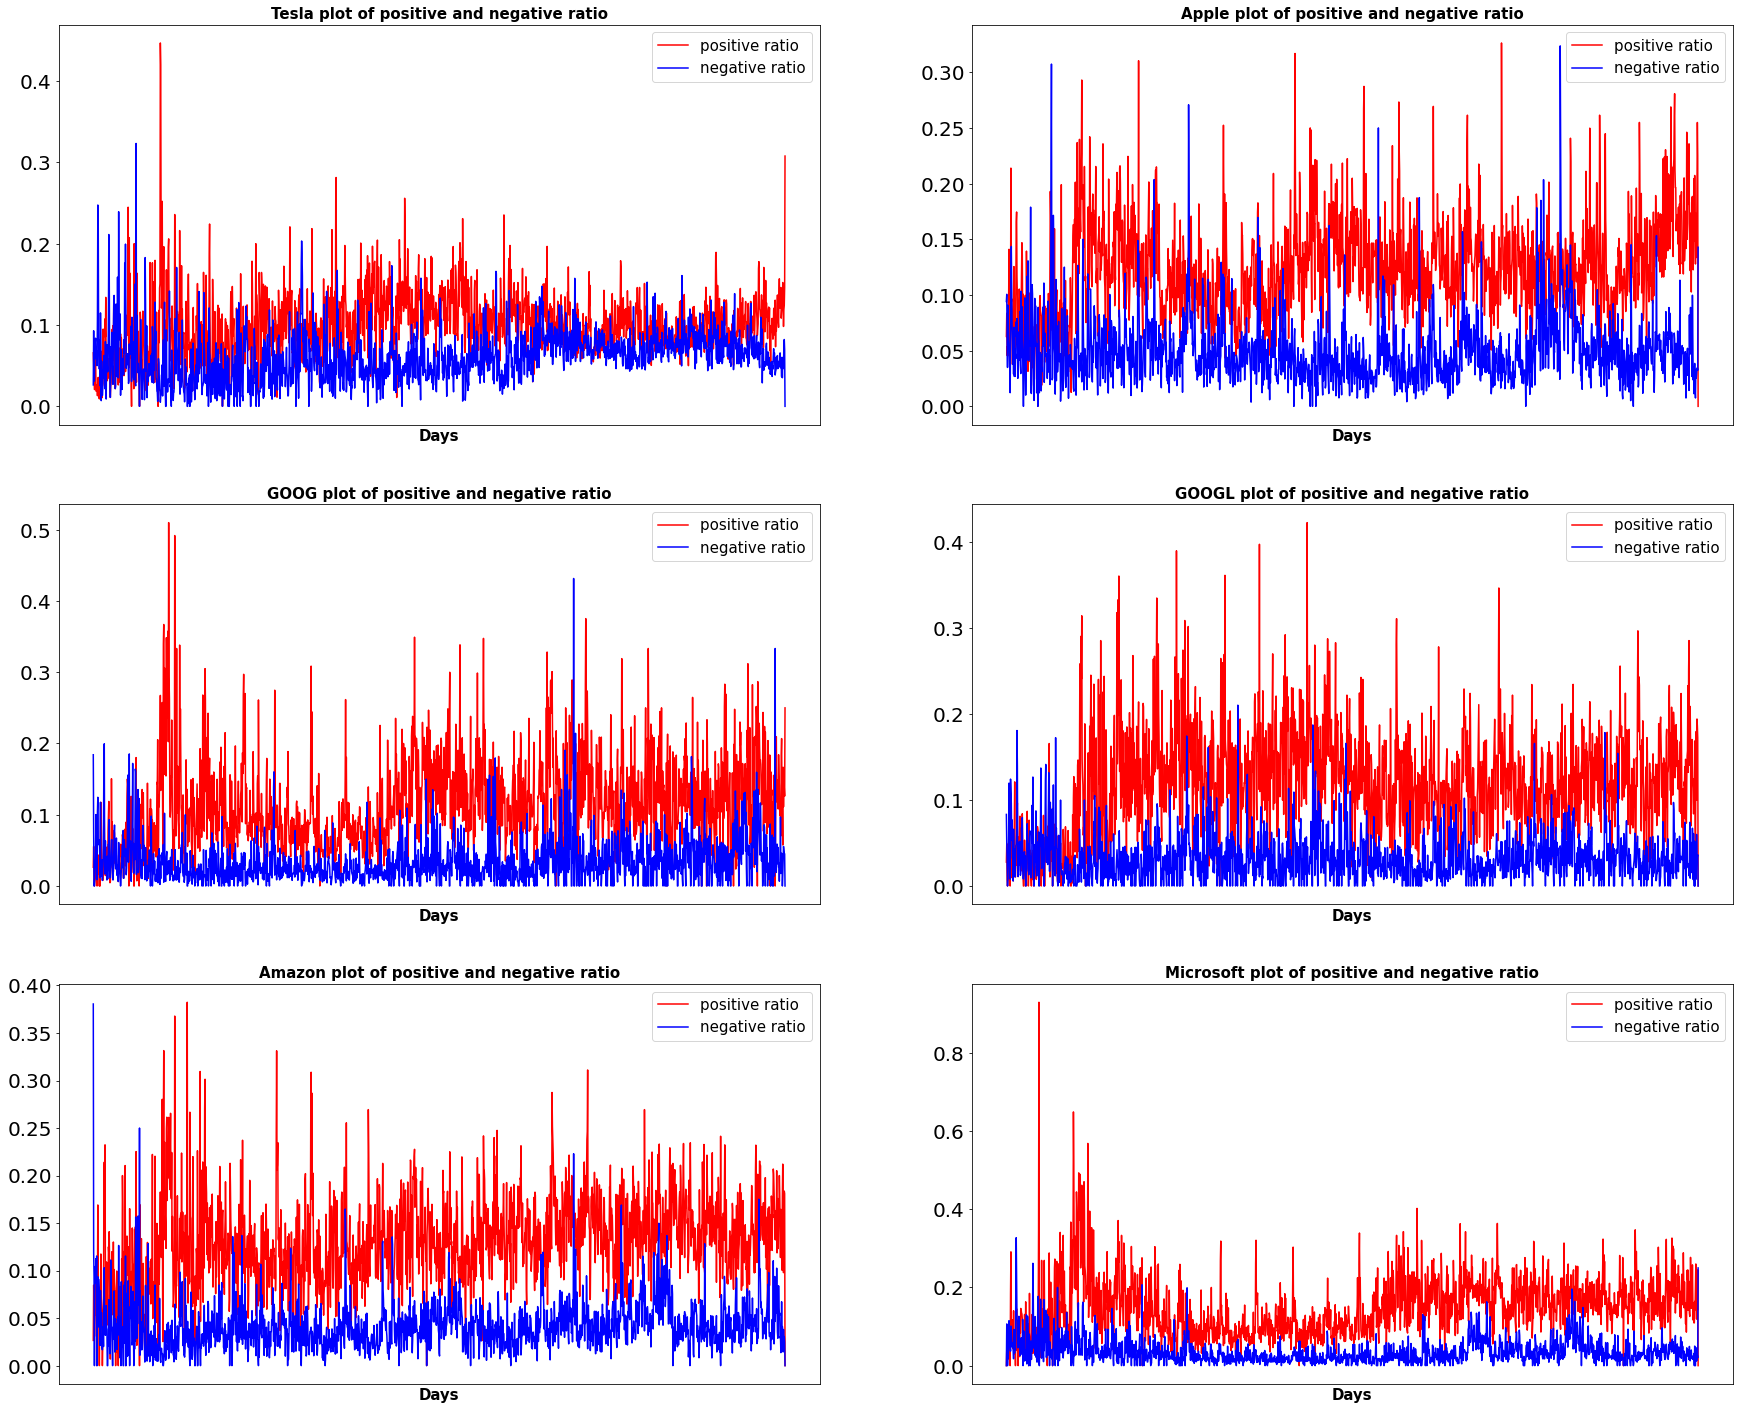

In [21]:
company_name_list = ['Tesla', 'Apple', 'GOOG', 'GOOGL', 'Amazon', 'Microsoft']

fig, axes = plt.subplots(3,2,figsize=(30,25))
axes_list = axes.flatten() #sublots axes

for i,ax in enumerate(axes_list):
    ax.set_title(f'{company_name_list[i]} plot of positive and negative ratio',
                 fontdict={'fontsize':15,'fontweight' : 'bold'})
    c1, = ax.plot(ratio_df_list[i]['date'],ratio_df_list[i]['pos_ratio'],color="red",)
    c2, = ax.plot(ratio_df_list[i]['date'],ratio_df_list[i]['neg_ratio'],color="blue")

    ax.legend([c1, c2,],['positive ratio', 'negative ratio'],fontsize=15)
    ax.set_xlabel('Days',fontsize=15, fontweight='bold')
    ax.set_xticks([])
    
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)

In [22]:
final_ratio_df_list[0]

,date,logreturn,pos_ratio,neg_ratio,tweet_volume
0,2019-10-24,0.162707,0.177886,0.074931,3283
1,2018-10-01,0.159966,0.137018,0.060335,2569
2,2018-08-02,0.150039,0.165620,0.062821,3502
3,2018-10-23,0.119727,0.130712,0.061637,1882
4,2015-11-04,0.105922,0.224138,0.066092,696
...,...,...,...,...,...
1821,2016-06-22,-0.110377,0.080834,0.087788,2301
1822,2019-01-18,-0.138930,0.102618,0.134713,2368
1823,2019-07-25,-0.146341,0.130824,0.119269,2683
1824,2018-09-28,-0.149679,0.076186,0.094906,4594


In [23]:
final_df_list[0]

,date,logreturn,pos_num,neg_num,tweet_volume
0,2019-10-24,0.162707,584,246,3283
1,2018-10-01,0.159966,352,155,2569
2,2018-08-02,0.150039,580,220,3502
3,2018-10-23,0.119727,246,116,1882
4,2015-11-04,0.105922,156,46,696
...,...,...,...,...,...
1821,2016-06-22,-0.110377,186,202,2301
1822,2019-01-18,-0.138930,243,319,2368
1823,2019-07-25,-0.146341,351,320,2683
1824,2018-09-28,-0.149679,350,436,4594


In [24]:
str_date_lst_list = []
for final_df in final_df_list:
    str_date_list = [ day.strftime('%m/%d/%Y')for day in final_df['date']]
    str_date_lst_list.append(str_date_list)

In [25]:
final_ratio_df_list[0]

,date,logreturn,pos_ratio,neg_ratio,tweet_volume
0,2019-10-24,0.162707,0.177886,0.074931,3283
1,2018-10-01,0.159966,0.137018,0.060335,2569
2,2018-08-02,0.150039,0.165620,0.062821,3502
3,2018-10-23,0.119727,0.130712,0.061637,1882
4,2015-11-04,0.105922,0.224138,0.066092,696
...,...,...,...,...,...
1821,2016-06-22,-0.110377,0.080834,0.087788,2301
1822,2019-01-18,-0.138930,0.102618,0.134713,2368
1823,2019-07-25,-0.146341,0.130824,0.119269,2683
1824,2018-09-28,-0.149679,0.076186,0.094906,4594


In [26]:
for final_ratio_df in final_ratio_df_list:
    final_ratio_df['absolute_logreturn'] = final_ratio_df['logreturn'].abs()
    
final_ratio_df_list[0]

,date,logreturn,pos_ratio,neg_ratio,tweet_volume,absolute_logreturn
0,2019-10-24,0.162707,0.177886,0.074931,3283,0.162707
1,2018-10-01,0.159966,0.137018,0.060335,2569,0.159966
2,2018-08-02,0.150039,0.165620,0.062821,3502,0.150039
3,2018-10-23,0.119727,0.130712,0.061637,1882,0.119727
4,2015-11-04,0.105922,0.224138,0.066092,696,0.105922
...,...,...,...,...,...,...
1821,2016-06-22,-0.110377,0.080834,0.087788,2301,0.110377
1822,2019-01-18,-0.138930,0.102618,0.134713,2368,0.138930
1823,2019-07-25,-0.146341,0.130824,0.119269,2683,0.146341
1824,2018-09-28,-0.149679,0.076186,0.094906,4594,0.149679


In [32]:
tweet_vol_df_list = []
for final_ratio_df in final_ratio_df_list:
    tweet_vol_df = final_ratio_df[['date','tweet_volume']]
    tweet_vol_df_list.append(tweet_vol_df)
tweet_vol_df_list[0]

,date,tweet_volume
0,2019-10-24,3283
1,2018-10-01,2569
2,2018-08-02,3502
3,2018-10-23,1882
4,2015-11-04,696
...,...,...
1821,2016-06-22,2301
1822,2019-01-18,2368
1823,2019-07-25,2683
1824,2018-09-28,4594


Tesla plot of positive and negative ratio


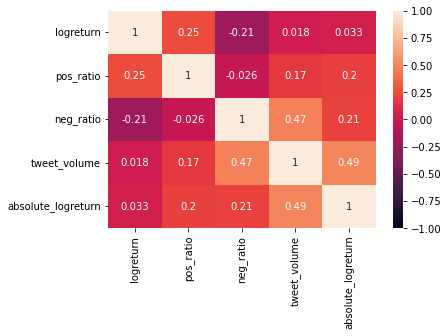

Apple plot of positive and negative ratio


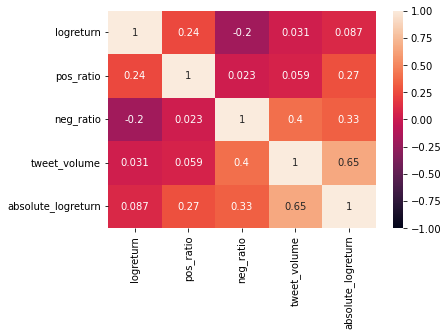

GOOG plot of positive and negative ratio


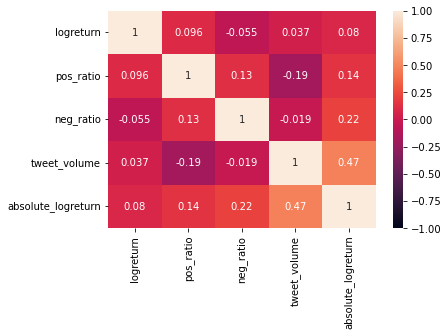

GOOGL plot of positive and negative ratio


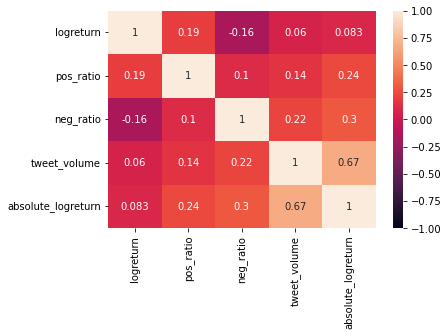

Amazon plot of positive and negative ratio


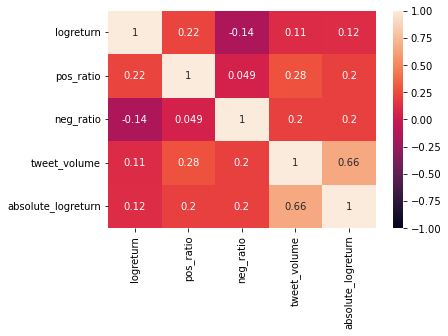

Microsoft plot of positive and negative ratio


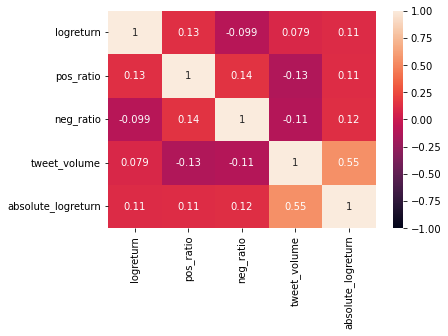

In [29]:
import seaborn as sns
%matplotlib inline

company_name_list = ['Tesla', 'Apple', 'GOOG', 'GOOGL', 'Amazon', 'Microsoft']

for i,name in enumerate(company_name_list):
    print(f'{name} plot of positive and negative ratio',flush=True)
    corr = final_ratio_df_list[i].corr(method='spearman')
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, vmin=-1, vmax=1, annot=True)
    
    ax.set_xticks([])
    plt.show()

In [30]:
import numpy as np
from scipy import stats

company_name_list = ['Tesla', 'Apple', 'GOOG', 'GOOGL', 'Amazon', 'Microsoft']

for i,name in enumerate(company_name_list):
    print(f'{name} plot of positive and negative ratio',flush=True)
    res = stats.spearmanr(final_ratio_df_list[i][['logreturn','pos_ratio','neg_ratio','tweet_volume','absolute_logreturn']])
    #print('Correration matrix')
    #print(res.correlation)
    #print()
    print('p value')
    print(np.round(res.pvalue,3))
    print()

Tesla plot of positive and negative ratio
p value
[[0.    0.    0.    0.477 0.144]
 [0.    0.    0.258 0.    0.   ]
 [0.    0.258 0.    0.    0.   ]
 [0.477 0.    0.    0.    0.   ]
 [0.144 0.    0.    0.    0.   ]]

Apple plot of positive and negative ratio
p value
[[0.    0.    0.    0.204 0.   ]
 [0.    0.    0.329 0.012 0.   ]
 [0.    0.329 0.    0.    0.   ]
 [0.204 0.012 0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]]

GOOG plot of positive and negative ratio
p value
[[0.    0.    0.022 0.134 0.   ]
 [0.    0.    0.    0.    0.   ]
 [0.022 0.    0.    0.405 0.   ]
 [0.134 0.    0.405 0.    0.   ]
 [0.    0.    0.    0.    0.   ]]

GOOGL plot of positive and negative ratio
p value
[[0.    0.    0.    0.012 0.   ]
 [0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]
 [0.012 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]]

Amazon plot of positive and negative ratio
p value
[[0.    0.    0.    0.    0.   ]
 [0.    0.    0.038 0.    0.   ]
 [0.    0.038 0.

# Using data, which contains only weekdays

In [34]:
save_path = 'C:\\Users\\homol\\Documents\\diplomamunka\\adat\\'

In [35]:
weekday_stock_metrics_df_list = load_pickle(save_path+'weekday_stock_metrics_df_list.p')
weekday_sent_df_list = load_pickle(save_path+'weekday_sent_df_list.p')
weekday_stock_metrics_df_list[0]

,ticker_symbol,date,close_value,volume,open_value,high_value,low_value,weekday_digit,logreturn,open_close_delta
0,TSLA,2015-01-01,222.41,2392947,223.090,225.68,222.2500,3,NaN,NaN
1,TSLA,2015-01-02,219.31,4753239,222.870,223.25,213.2600,4,-0.014036,-0.002064
2,TSLA,2015-01-05,210.09,5355485,214.550,216.50,207.1626,0,-0.042950,0.022186
3,TSLA,2015-01-06,211.28,6257651,210.060,214.20,204.2100,1,0.005648,0.000143
4,TSLA,2015-01-07,210.95,2965330,213.350,214.78,209.7800,2,-0.001563,-0.009702
...,...,...,...,...,...,...,...,...,...,...
1402,TSLA,2020-05-22,816.88,9987475,822.174,831.78,812.0000,4,-0.013038,0.006600
1403,TSLA,2020-05-26,818.87,8089736,834.500,834.60,815.7050,1,0.002433,-0.021114
1404,TSLA,2020-05-27,820.23,11549530,820.860,827.71,785.0000,2,0.001659,-0.002424
1405,TSLA,2020-05-28,805.81,7275774,813.510,824.75,801.6900,3,-0.017737,0.008261


In [36]:
weekday_sent_df_list[0]

,date,pos_ratio,neg_ratio
0,2015-01-01,0.034483,0.034483
1,2015-01-05,0.049383,0.086420
2,2015-01-06,0.062500,0.041667
3,2015-01-07,0.073171,0.121951
4,2015-01-08,0.031008,0.069767
...,...,...,...
1038,2019-12-24,0.122059,0.061765
1039,2019-12-25,0.114907,0.074534
1040,2019-12-26,0.139513,0.046816
1041,2019-12-30,0.125864,0.089903


In [37]:
weekday_stock_sent_df_list = []
for i,sent_df in enumerate(weekday_sent_df_list):
    stock_sent_df = pd.merge(weekday_stock_metrics_df_list[i],sent_df,on='date')
    weekday_stock_sent_df_list.append(stock_sent_df)

In [38]:
weekday_stock_sent_df_list[0]

,ticker_symbol,date,close_value,volume,open_value,high_value,low_value,weekday_digit,logreturn,open_close_delta,pos_ratio,neg_ratio
0,TSLA,2015-01-01,222.410,2392947,223.09,225.6800,222.2500,3,NaN,NaN,0.034483,0.034483
1,TSLA,2015-01-05,210.090,5355485,214.55,216.5000,207.1626,0,-0.042950,0.022186,0.049383,0.086420
2,TSLA,2015-01-06,211.280,6257651,210.06,214.2000,204.2100,1,0.005648,0.000143,0.062500,0.041667
3,TSLA,2015-01-07,210.950,2965330,213.35,214.7800,209.7800,2,-0.001563,-0.009702,0.073171,0.121951
4,TSLA,2015-01-08,210.615,3434901,212.81,213.7999,210.0100,3,-0.001589,-0.008740,0.031008,0.069767
...,...,...,...,...,...,...,...,...,...,...,...,...
1038,TSLA,2019-12-24,425.250,8054720,418.36,425.4700,412.6875,1,0.014281,0.002056,0.122059,0.061765
1039,TSLA,2019-12-25,425.250,8054720,418.36,425.4700,412.6875,2,0.000000,0.016469,0.114907,0.074534
1040,TSLA,2019-12-26,430.940,10648290,427.91,433.4800,426.3500,3,0.013292,-0.006216,0.139513,0.046816
1041,TSLA,2019-12-30,414.700,12601270,428.79,429.0000,409.2589,0,-0.037113,0.003708,0.125864,0.089903


In [39]:
for weekday_stock_sent_df in weekday_stock_sent_df_list:
    weekday_stock_sent_df['absolute_logreturn'] = weekday_stock_sent_df['logreturn'].abs()
    
weekday_stock_sent_df_list[0]

,ticker_symbol,date,close_value,volume,open_value,high_value,low_value,weekday_digit,logreturn,open_close_delta,pos_ratio,neg_ratio,absolute_logreturn
0,TSLA,2015-01-01,222.410,2392947,223.09,225.6800,222.2500,3,NaN,NaN,0.034483,0.034483,NaN
1,TSLA,2015-01-05,210.090,5355485,214.55,216.5000,207.1626,0,-0.042950,0.022186,0.049383,0.086420,0.042950
2,TSLA,2015-01-06,211.280,6257651,210.06,214.2000,204.2100,1,0.005648,0.000143,0.062500,0.041667,0.005648
3,TSLA,2015-01-07,210.950,2965330,213.35,214.7800,209.7800,2,-0.001563,-0.009702,0.073171,0.121951,0.001563
4,TSLA,2015-01-08,210.615,3434901,212.81,213.7999,210.0100,3,-0.001589,-0.008740,0.031008,0.069767,0.001589
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038,TSLA,2019-12-24,425.250,8054720,418.36,425.4700,412.6875,1,0.014281,0.002056,0.122059,0.061765,0.014281
1039,TSLA,2019-12-25,425.250,8054720,418.36,425.4700,412.6875,2,0.000000,0.016469,0.114907,0.074534,0.000000
1040,TSLA,2019-12-26,430.940,10648290,427.91,433.4800,426.3500,3,0.013292,-0.006216,0.139513,0.046816,0.013292
1041,TSLA,2019-12-30,414.700,12601270,428.79,429.0000,409.2589,0,-0.037113,0.003708,0.125864,0.089903,0.037113


In [40]:
spearman_df_list = []
for i,weekday_stock_sent_df in enumerate(weekday_stock_sent_df_list):
    spearman_df = pd.merge(weekday_stock_sent_df[['date','logreturn','pos_ratio','neg_ratio','absolute_logreturn']],
                           tweet_vol_df_list[i],on='date')
    spearman_df_list.append(spearman_df)
spearman_df_list[0]

,date,logreturn,pos_ratio,neg_ratio,absolute_logreturn,tweet_volume
0,2015-01-01,NaN,0.034483,0.034483,NaN,76
1,2015-01-05,-0.042950,0.049383,0.086420,0.042950,218
2,2015-01-06,0.005648,0.062500,0.041667,0.005648,168
3,2015-01-07,-0.001563,0.073171,0.121951,0.001563,203
4,2015-01-08,-0.001589,0.031008,0.069767,0.001589,171
...,...,...,...,...,...,...
1038,2019-12-24,0.014281,0.122059,0.061765,0.014281,1227
1039,2019-12-25,0.000000,0.114907,0.074534,0.000000,398
1040,2019-12-26,0.013292,0.139513,0.046816,0.013292,1097
1041,2019-12-30,-0.037113,0.125864,0.089903,0.037113,1266


Tesla plot of positive and negative ratio


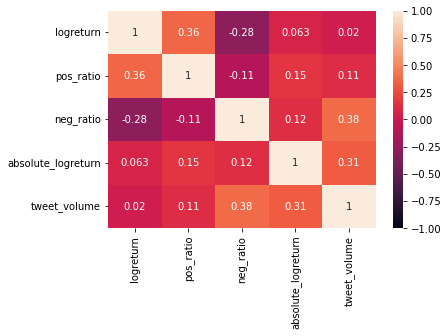

Apple plot of positive and negative ratio


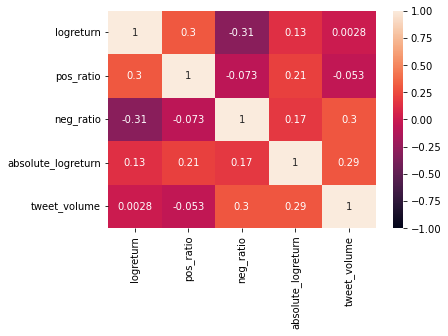

GOOG plot of positive and negative ratio


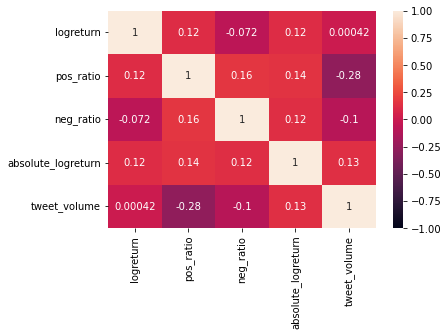

GOOGL plot of positive and negative ratio


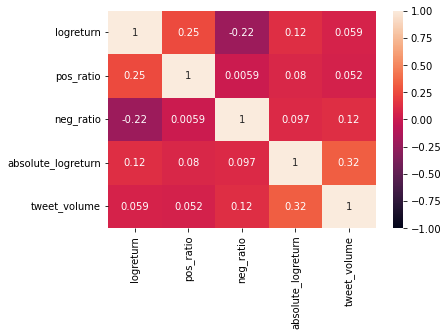

Amazon plot of positive and negative ratio


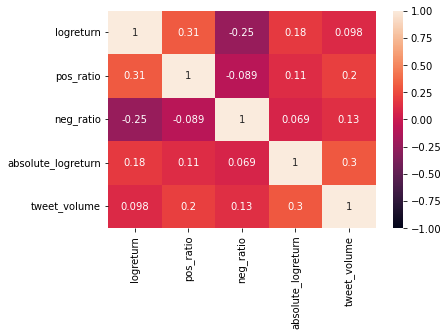

Microsoft plot of positive and negative ratio


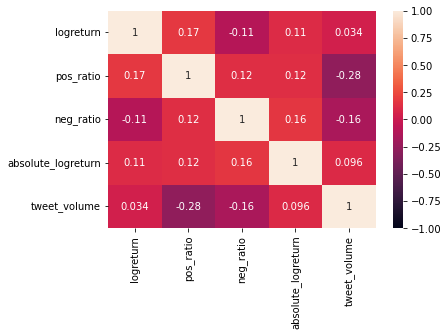

In [41]:
import seaborn as sns
%matplotlib inline

company_name_list = ['Tesla', 'Apple', 'GOOG', 'GOOGL', 'Amazon', 'Microsoft']

for i,name in enumerate(company_name_list):
    print(f'{name} plot of positive and negative ratio',flush=True)
    corr = spearman_df_list[i].corr(method='spearman')
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, vmin=-1, vmax=1, annot=True)
    
    ax.set_xticks([])
    plt.show()

In [42]:
import numpy as np
from scipy import stats

company_name_list = ['Tesla', 'Apple', 'GOOG', 'GOOGL', 'Amazon', 'Microsoft']

for i,name in enumerate(company_name_list):
    print(f'{name} plot of positive and negative ratio',flush=True)
    res = stats.spearmanr(spearman_df_list[i][['logreturn','pos_ratio','neg_ratio','tweet_volume','absolute_logreturn']])
    print('p value')
    print(np.round(res.pvalue,3))
    print()

Tesla plot of positive and negative ratio
p value
[[0.    0.    0.    0.588 0.034]
 [0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]
 [0.588 0.    0.    0.    0.   ]
 [0.034 0.    0.    0.    0.   ]]

Apple plot of positive and negative ratio
p value
[[0.    0.    0.    0.999 0.   ]
 [0.    0.    0.019 0.087 0.   ]
 [0.    0.019 0.    0.    0.   ]
 [0.999 0.087 0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]]

GOOG plot of positive and negative ratio
p value
[[0.    0.    0.016 0.938 0.   ]
 [0.    0.    0.    0.    0.   ]
 [0.016 0.    0.    0.001 0.   ]
 [0.938 0.    0.001 0.    0.   ]
 [0.    0.    0.    0.    0.   ]]

GOOGL plot of positive and negative ratio
p value
[[0.    0.    0.    0.072 0.   ]
 [0.    0.    0.849 0.095 0.012]
 [0.    0.849 0.    0.    0.002]
 [0.072 0.095 0.    0.    0.   ]
 [0.    0.012 0.002 0.    0.   ]]

Amazon plot of positive and negative ratio
p value
[[0.    0.    0.    0.002 0.   ]
 [0.    0.    0.004 0.    0.   ]
 [0.    0.004 0.